In [137]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [138]:
# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

# Education-based salary adjustments
def generate_salary_by_education(industry_base_range, education_level):
    base_min, base_max = industry_base_range
    
    # Salary multipliers based on education
    education_multipliers = {
        "High School": np.random.uniform(0.7, 1.0),
        "Diploma": np.random.uniform(0.8, 1.3),
        "Bachelor's": np.random.uniform(1.0, 1.6),
        "Master's": np.random.uniform(1.2, 1.9),
        "PhD": np.random.uniform(1.4, 2.3)
    }
    
    multiplier = education_multipliers[education_level]
    salary = int(np.random.uniform(base_min * multiplier, base_max * multiplier))
    
    # Add random noise to salary
    noise = np.random.normal(0, salary * 0.05)  # 5% noise
    return max(3000, int(salary + noise))  # Ensure minimum salary
    
# Generate synthetic dataset size
num_samples = 10000

# Age range (22-35 years old)
ages = np.random.randint(22, 36, num_samples)

# Gender distribution
genders = np.random.choice(["Male", "Female"], num_samples, p=[0.48, 0.52])

# Race distribution based on SA demographics
races = np.random.choice(
    ["Black African", "Coloured", "Indian/Asian", "White"], 
    num_samples, 
    p=[0.80, 0.09, 0.05, 0.06]
)

# Education levels with more realistic distribution
education_levels = np.random.choice(
    ["High School", "Diploma", "Bachelor's", "Master's", "PhD"], 
    num_samples, 
    p=[0.4, 0.3, 0.2, 0.08, 0.02]
)

# Industry-based salary distributions based on Stats SA report
industry_categories = ["Retail", "Finance", "Mining", "IT", "Healthcare", "Education", "Construction"]
industry_salaries = {
    "Retail": (3000, 8000),
    "Finance": (7000, 35000),
    "Mining": (10000, 40000),
    "IT": (9000, 40000),
    "Healthcare": (7000, 30000),
    "Education": (5000, 25000),
    "Construction": (4000, 15000)
}

# Generate industries
industries = np.random.choice(list(industry_salaries.keys()), num_samples)

# Generate industries and salaries with education-based adjustments
salaries = np.array([
    generate_salary_by_education(
        industry_salaries[ind], 
        edu
    ) for ind, edu in zip(industries, education_levels)
])


In [139]:
# Working hours (full-time vs part-time)
weekly_hours = np.random.choice([20, 30, 40, 45, 50], num_samples, p=[0.1, 0.2, 0.4, 0.2, 0.1])

# Expense categories (percent of salary based on realistic spending habits)
rent_percentage = np.random.uniform(0.3, 0.4, num_samples)
transport_percentage = np.random.uniform(0.1, 0.15, num_samples)
groceries_percentage = np.random.uniform(0.15, 0.2, num_samples)
debt_repayment_percentage = np.random.uniform(0.05, 0.6, num_samples)
savings_percentage = np.random.uniform(0.05, 0.25, num_samples)
entertainment_percentage = np.random.uniform(0.15, 0.2, num_samples)

# Calculate expenses
rent = salaries * rent_percentage
transport = salaries * transport_percentage
groceries = salaries * groceries_percentage
debt_repayment = salaries * debt_repayment_percentage
savings = salaries * savings_percentage
entertainment = salaries * entertainment_percentage
# Total expenses
total_expenses = rent + transport + groceries + debt_repayment + entertainment


In [140]:
# Enhanced Debt Risk Classification
def classify_debt_risk(row):
    """Improved debt classification without randomness."""
    salary = row['Salary (ZAR)']
    dti = (row['Debt Repayment (ZAR)'] / salary) * 100  # Debt-to-Income Ratio
    total_expenses = row[['Rent (ZAR)', 'Transport (ZAR)', 'Groceries (ZAR)', 
                          'Debt Repayment (ZAR)', 'Entertainment (ZAR)']].sum()
    
    
    # Risk Classification
    if total_expenses > salary * 1.2 or dti > 45:  
        return "Critical Risk"  
    elif total_expenses > salary and dti > 30:  
        return "High Risk"  
    elif total_expenses > salary and dti > 20:  
        return "Moderate Risk"  
    elif dti > 15:  
        return "Low Risk"  
    else:  
        return "Very Low Risk"  

# Create DataFrame
data = pd.DataFrame({
    "Age": ages,
    "Gender": genders,
    "Race": races,
    "Education Level": education_levels,
    "Industry": industries,
    "Weekly Hours Worked": weekly_hours,
    "Salary (ZAR)": salaries,
    "Rent (ZAR)": rent.round(2),
    "Transport (ZAR)": transport.round(2),
    "Groceries (ZAR)": groceries.round(2),
    "Debt Repayment (ZAR)": debt_repayment.round(2),
    "Savings (ZAR)": savings.round(2),
    "Entertainment (ZAR)": entertainment.round(2),
    "Total Expenses (ZAR)": total_expenses.round(2),
    "Debt-to-Income Ratio (%)": (debt_repayment / salaries * 100).round(2)
})

# Apply the function
data['Debt Risk Level'] = data.apply(classify_debt_risk, axis=1)

data.to_csv('raw_debt_risk_dataset.csv', index=False)

In [141]:
print(data.head())

   Age  Gender           Race Education Level    Industry  \
0   28    Male  Black African      Bachelor's          IT   
1   25    Male  Black African     High School          IT   
2   34  Female  Black African      Bachelor's   Education   
3   32    Male  Black African         Diploma   Education   
4   29  Female  Black African     High School  Healthcare   

   Weekly Hours Worked  Salary (ZAR)  Rent (ZAR)  Transport (ZAR)  \
0                   40         33849    13486.41          3876.51   
1                   45         14784     4848.72          1950.67   
2                   45         22210     6777.67          2278.98   
3                   40         12505     4847.14          1619.73   
4                   30         19688     6123.94          2068.30   

   Groceries (ZAR)  Debt Repayment (ZAR)  Savings (ZAR)  Entertainment (ZAR)  \
0          6558.71              10528.13        2984.29              5747.36   
1          2421.23               5176.99        1704.95   

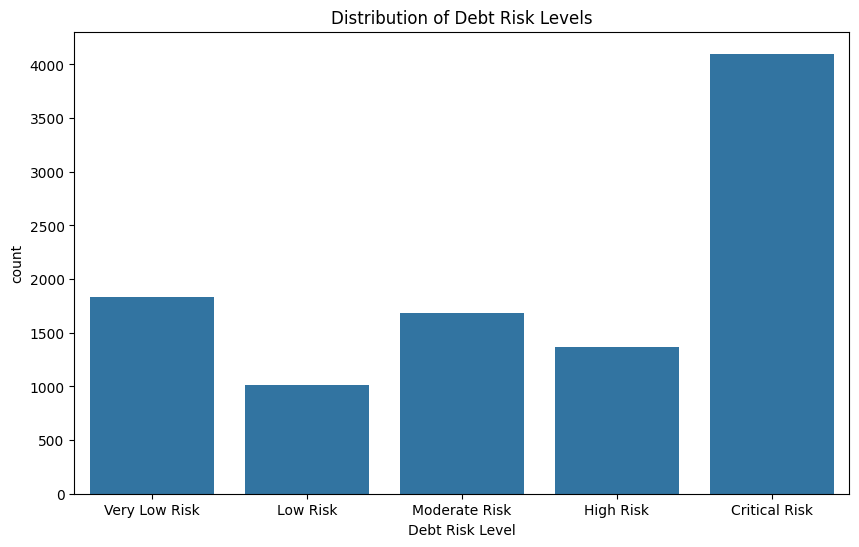

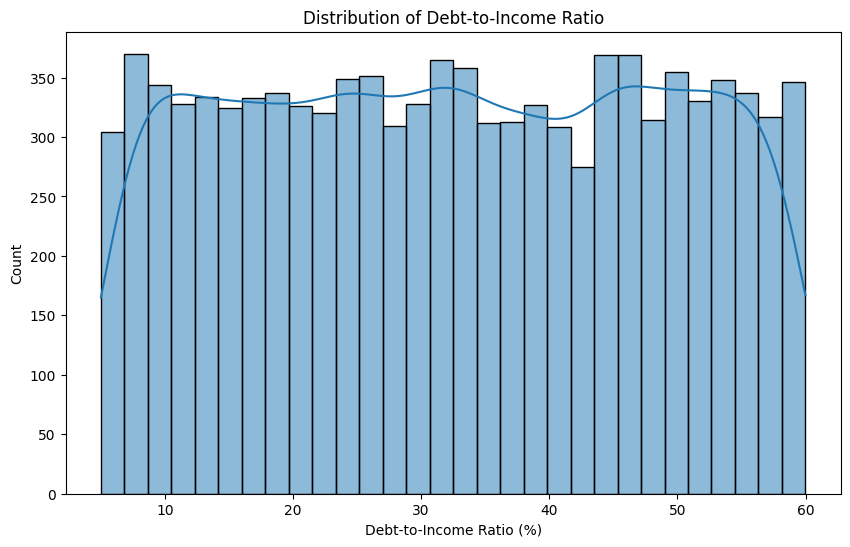

In [142]:
# Debt Risk Level Distribution
plt.figure(figsize=(10,6))
sns.countplot(data=data, x='Debt Risk Level', order=['Very Low Risk', 'Low Risk','Moderate Risk','High Risk', 'Critical Risk'])
plt.title('Distribution of Debt Risk Levels')
plt.show()

# Debt-to-Income Ratio Distribution
plt.figure(figsize=(10,6))
sns.histplot(data=data, x='Debt-to-Income Ratio (%)', kde=True, bins=30)
plt.title('Distribution of Debt-to-Income Ratio')
plt.show()

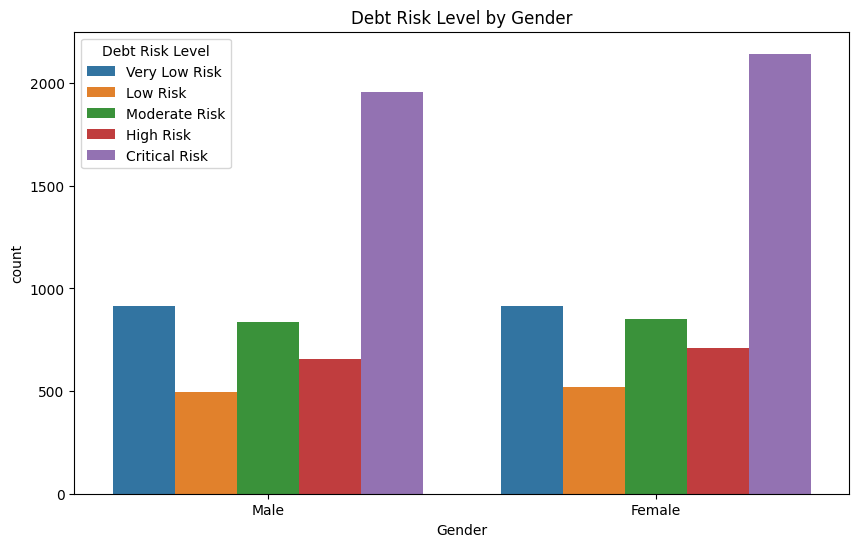

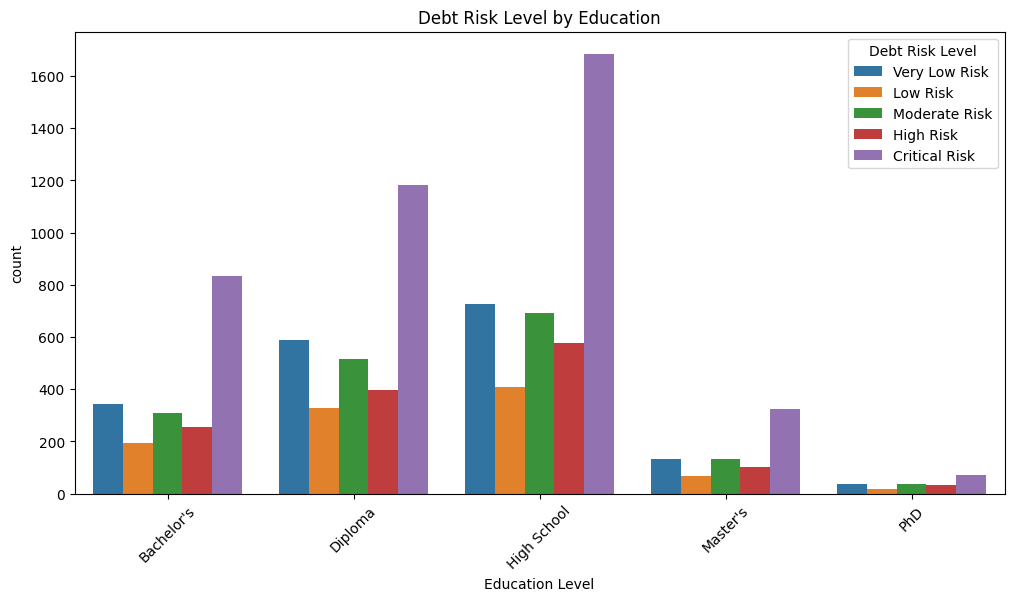

In [143]:
# Debt Risk by Gender
plt.figure(figsize=(10,6))
sns.countplot(data=data, x='Gender', hue='Debt Risk Level', 
              hue_order=['Very Low Risk', 'Low Risk','Moderate Risk','High Risk','Critical Risk'])
plt.title('Debt Risk Level by Gender')
plt.show()

# Debt Risk by Education Level
plt.figure(figsize=(12,6))
sns.countplot(data=data, x='Education Level', hue='Debt Risk Level', 
              order=sorted(data['Education Level'].unique()),
              hue_order=['Very Low Risk', 'Low Risk','Moderate Risk','High Risk','Critical Risk'])
plt.xticks(rotation=45)
plt.title('Debt Risk Level by Education')
plt.show()

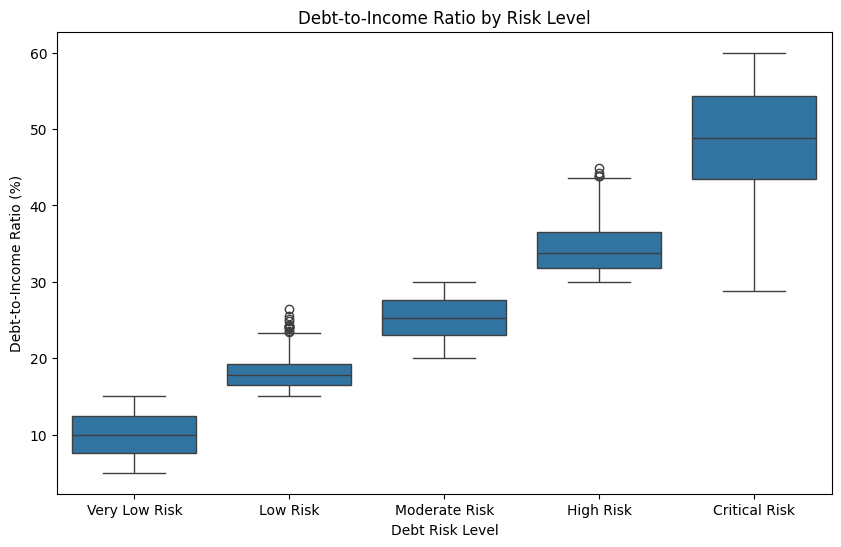

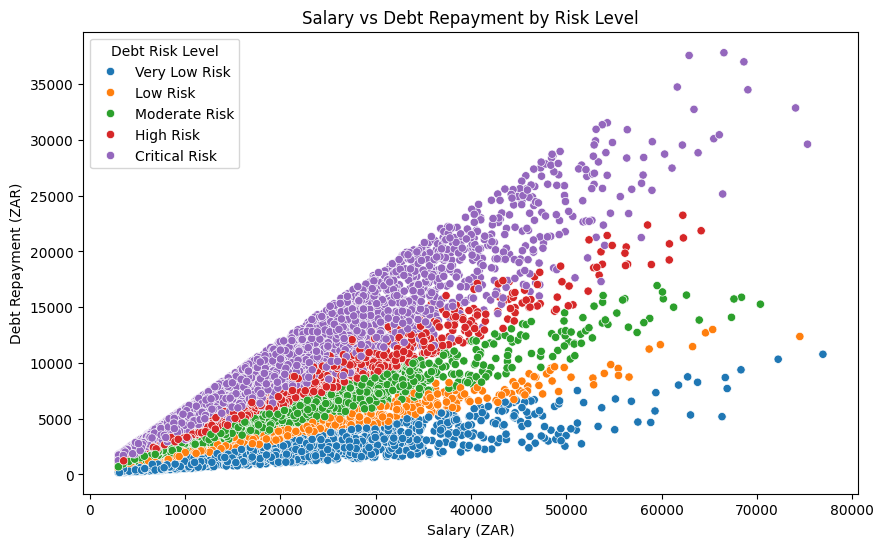

In [144]:
# Boxplot of Debt-to-Income Ratio by Risk Level
plt.figure(figsize=(10,6))
sns.boxplot(data=data, x='Debt Risk Level', y='Debt-to-Income Ratio (%)',
            order=['Very Low Risk', 'Low Risk','Moderate Risk','High Risk','Critical Risk'])
plt.title('Debt-to-Income Ratio by Risk Level')
plt.show()

# Scatter plot of Salary vs Debt Repayment colored by Risk Level
plt.figure(figsize=(10,6))
sns.scatterplot(data=data, x='Salary (ZAR)', y='Debt Repayment (ZAR)', 
                hue='Debt Risk Level', hue_order=['Very Low Risk', 'Low Risk','Moderate Risk','High Risk','Critical Risk'])
plt.title('Salary vs Debt Repayment by Risk Level')
plt.show()

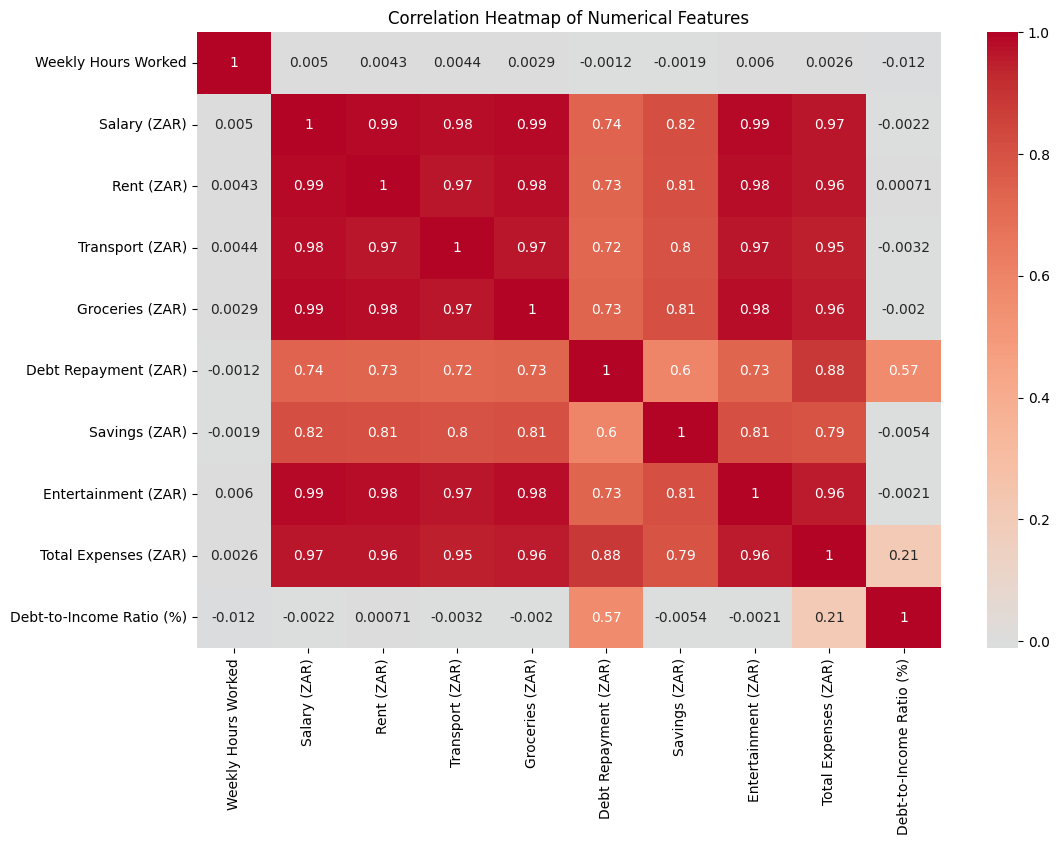

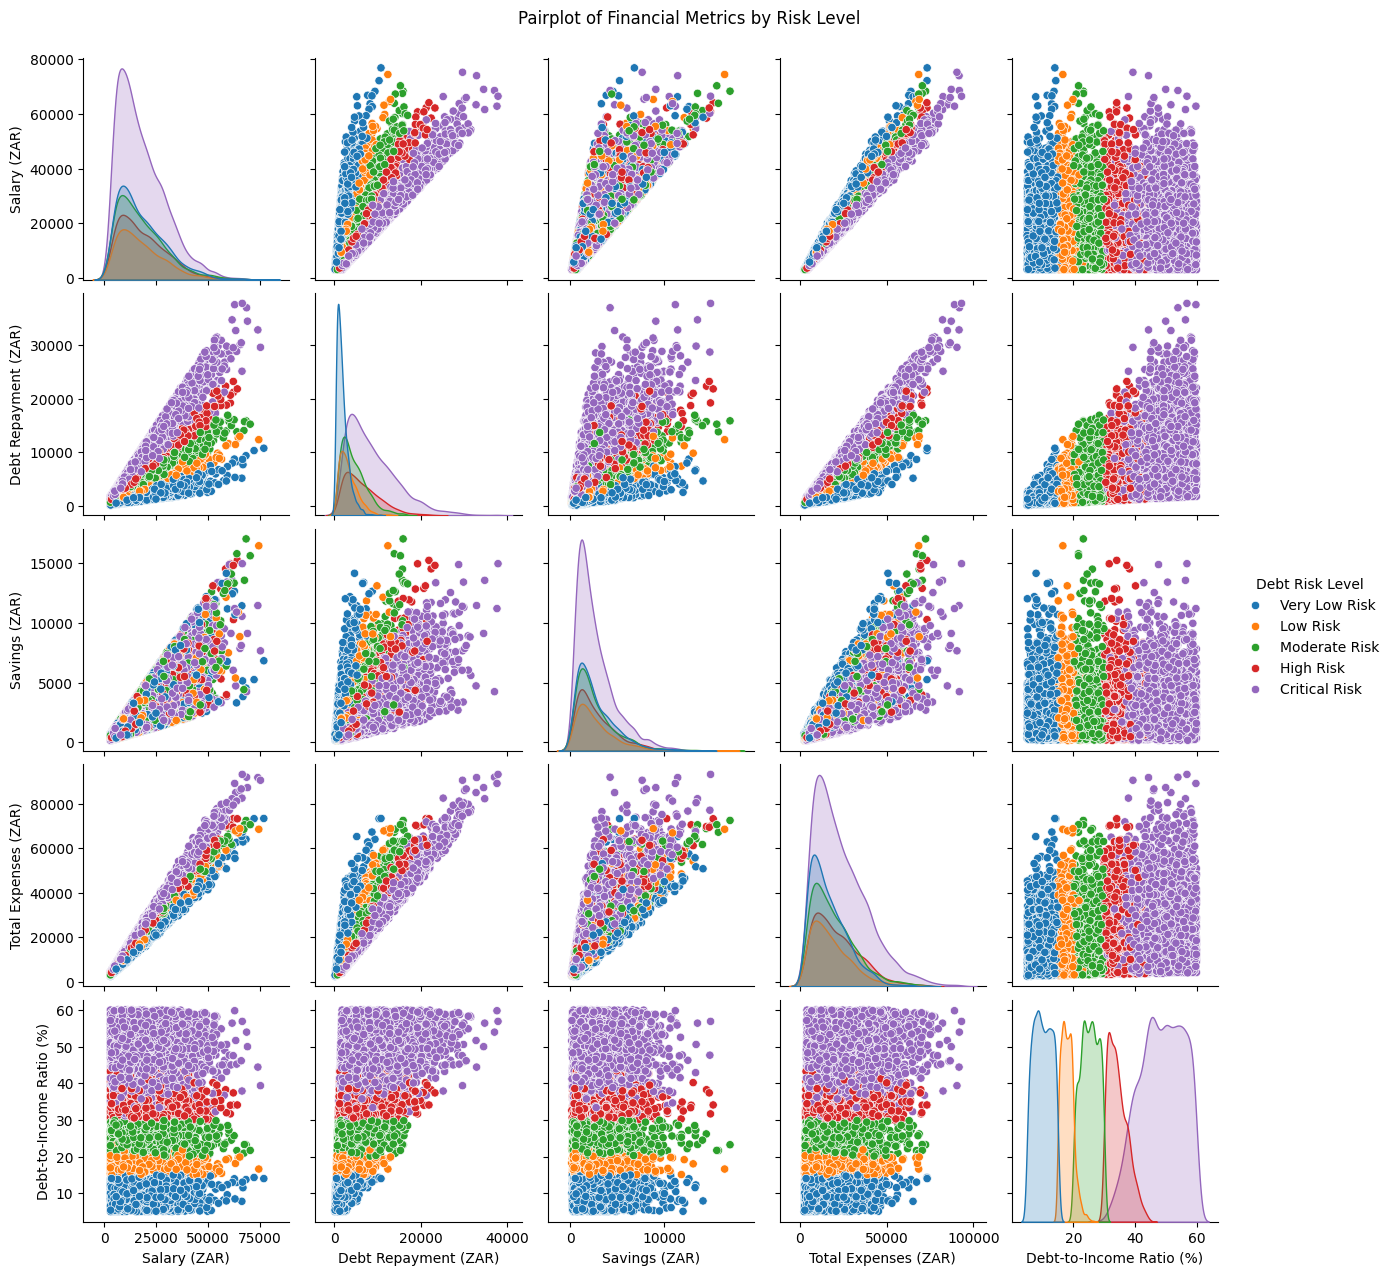

In [145]:
# Correlation heatmap
plt.figure(figsize=(12,8))
corr = data.select_dtypes(include=['float64', 'int64']).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

# Pairplot of key financial metrics
sns.pairplot(data[['Salary (ZAR)', 'Debt Repayment (ZAR)', 'Savings (ZAR)', 
                'Total Expenses (ZAR)', 'Debt-to-Income Ratio (%)', 
                'Debt Risk Level']], 
             hue='Debt Risk Level', hue_order=['Very Low Risk', 'Low Risk','Moderate Risk','High Risk','Critical Risk'])
plt.suptitle('Pairplot of Financial Metrics by Risk Level', y=1.02)
plt.show()

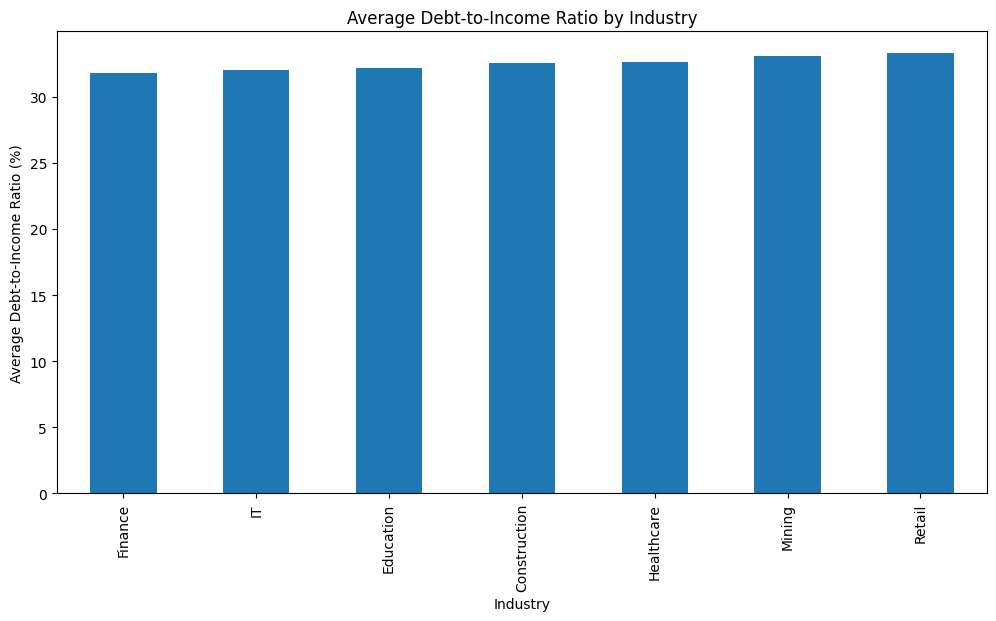

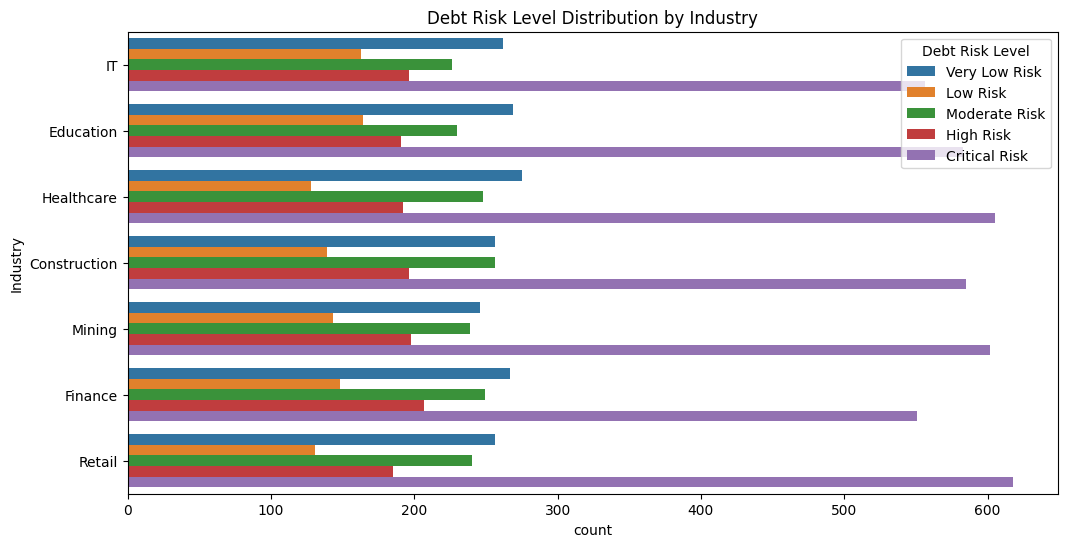

In [146]:
# Average Debt-to-Income by Industry
plt.figure(figsize=(12,6))
data.groupby('Industry')['Debt-to-Income Ratio (%)'].mean().sort_values().plot(kind='bar')
plt.title('Average Debt-to-Income Ratio by Industry')
plt.ylabel('Average Debt-to-Income Ratio (%)')
plt.show()

# Debt Risk Level by Industry
plt.figure(figsize=(12,6))
sns.countplot(data=data, y='Industry', hue='Debt Risk Level', 
              hue_order=['Very Low Risk', 'Low Risk','Moderate Risk','High Risk','Critical Risk'])
plt.title('Debt Risk Level Distribution by Industry')
plt.show()

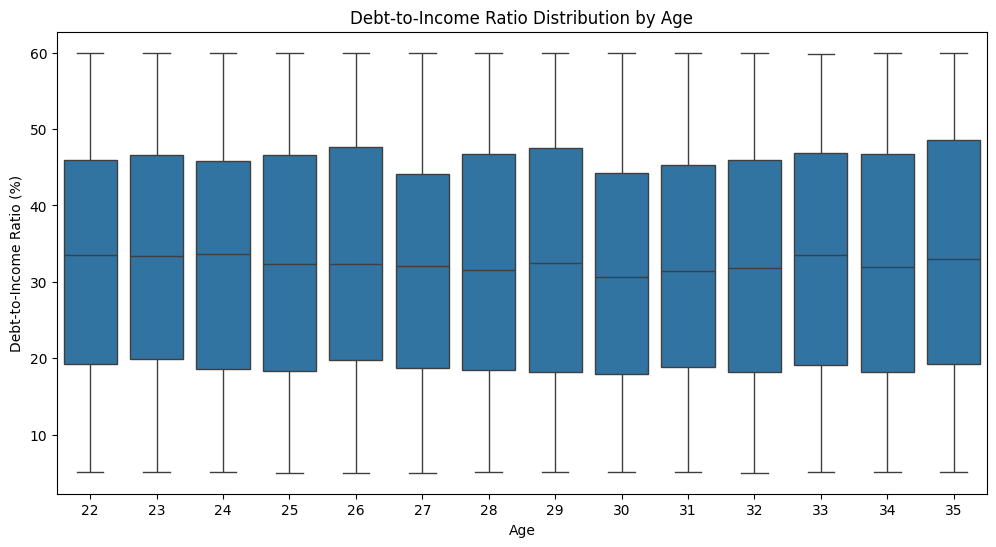

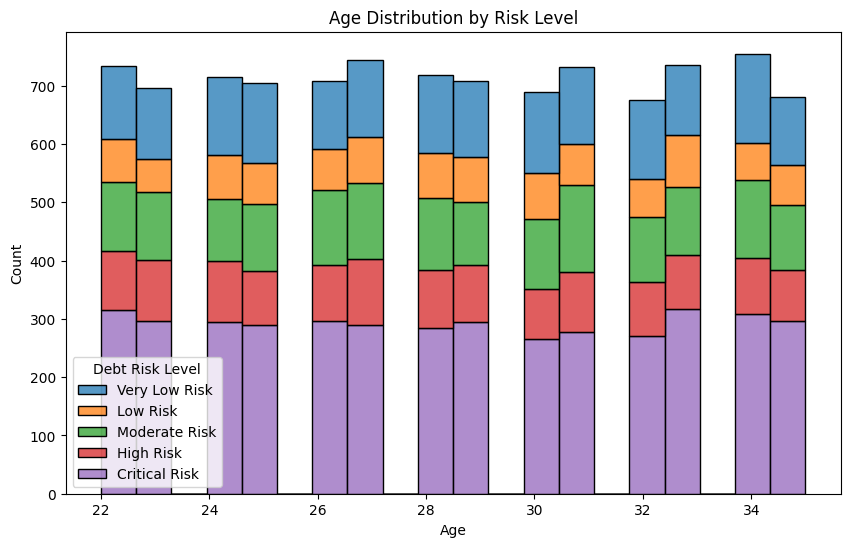

In [147]:
# Debt-to-Income Ratio by Age
plt.figure(figsize=(12,6))
sns.boxplot(data=data, x='Age', y='Debt-to-Income Ratio (%)')
plt.title('Debt-to-Income Ratio Distribution by Age')
plt.show()

# Age distribution by Risk Level
plt.figure(figsize=(10,6))
sns.histplot(data=data, x='Age', hue='Debt Risk Level', 
             hue_order=['Very Low Risk', 'Low Risk','Moderate Risk','High Risk','Critical Risk'], 
             multiple='stack', bins=20)
plt.title('Age Distribution by Risk Level')
plt.show()

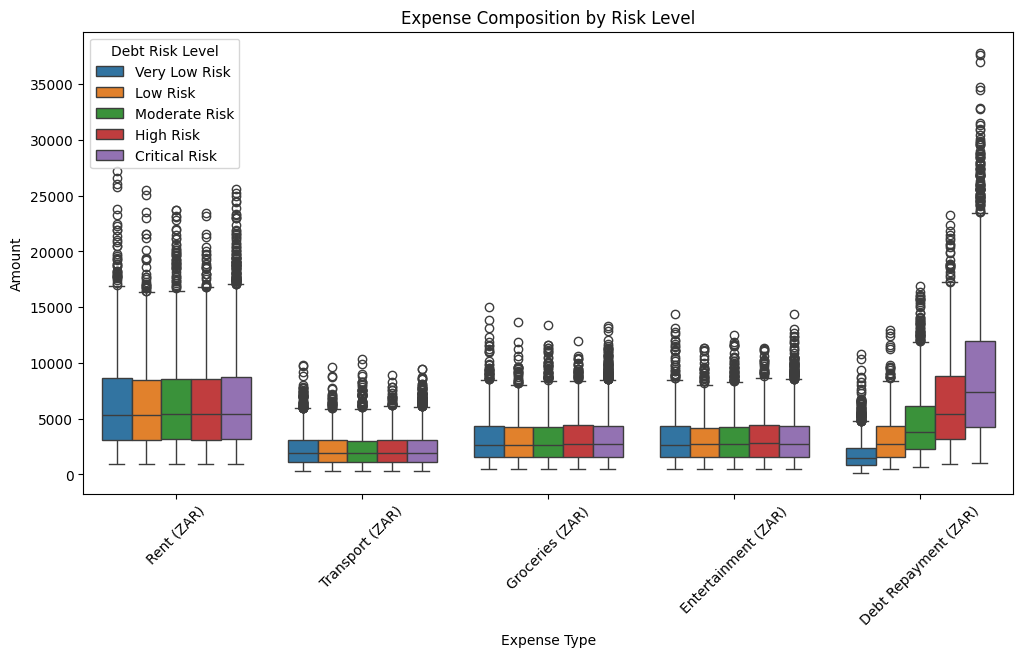

In [148]:
# Expense breakdown for different risk levels
expense_cols = ['Rent (ZAR)', 'Transport (ZAR)', 'Groceries (ZAR)', 
               'Entertainment (ZAR)', 'Debt Repayment (ZAR)']

plt.figure(figsize=(12,6))
df_melted = data.melt(id_vars=['Debt Risk Level'], value_vars=expense_cols, 
                    var_name='Expense Type', value_name='Amount')
sns.boxplot(data=df_melted, x='Expense Type', y='Amount', hue='Debt Risk Level',
            hue_order=['Very Low Risk', 'Low Risk','Moderate Risk','High Risk','Critical Risk'])
plt.xticks(rotation=45)
plt.title('Expense Composition by Risk Level')
plt.show()